In [1]:
from __future__ import print_function, division, absolute_import
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.model_zoo as model_zoo
import os
import sys
import numpy as np
import pandas as pd

import torch
from torch import nn
from torch.utils.data import DataLoader
import math
import einops
import numpy as np
from PIL import Image
import torchvision
import pandas as pd
import time
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

from utils import PlaneSet2Neurons, configurate_xy_tensors
from IPython.display import display

torch.manual_seed(42)

In [2]:
__all__ = ['InceptionV4', 'inceptionv4']

pretrained_settings = {
    'inceptionv4': {
        'imagenet': {
            'url': 'http://data.lip6.fr/cadene/pretrainedmodels/inceptionv4-8e4777a0.pth',
            'input_space': 'RGB',
            'input_size': [3, 299, 299],
            'input_range': [0, 1],
            'mean': [0.5, 0.5, 0.5],
            'std': [0.5, 0.5, 0.5],
            'num_classes': 1000
        },
        'imagenet+background': {
            'url': 'http://data.lip6.fr/cadene/pretrainedmodels/inceptionv4-8e4777a0.pth',
            'input_space': 'RGB',
            'input_size': [3, 299, 299],
            'input_range': [0, 1],
            'mean': [0.5, 0.5, 0.5],
            'std': [0.5, 0.5, 0.5],
            'num_classes': 1001
        }
    }
}

In [3]:
class BasicConv2d(nn.Module):

    def __init__(self, in_planes, out_planes, kernel_size, stride, padding=0):
        super(BasicConv2d, self).__init__()
        self.conv = nn.Conv2d(in_planes, out_planes,
                              kernel_size=kernel_size, stride=stride,
                              padding=padding, bias=False) # verify bias false
        self.bn = nn.BatchNorm2d(out_planes,
                                 eps=0.001, # value found in tensorflow
                                 momentum=0.1, # default pytorch value
                                 affine=True)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x


class Mixed_3a(nn.Module):

    def __init__(self):
        super(Mixed_3a, self).__init__()
        self.maxpool = nn.MaxPool2d(3, stride=2)
        self.conv = BasicConv2d(64, 96, kernel_size=3, stride=2)

    def forward(self, x):
        x0 = self.maxpool(x)
        x1 = self.conv(x)
        out = torch.cat((x0, x1), 1)
        return out


class Mixed_4a(nn.Module):

    def __init__(self):
        super(Mixed_4a, self).__init__()

        self.branch0 = nn.Sequential(
            BasicConv2d(160, 64, kernel_size=1, stride=1),
            BasicConv2d(64, 96, kernel_size=3, stride=1)
        )

        self.branch1 = nn.Sequential(
            BasicConv2d(160, 64, kernel_size=1, stride=1),
            BasicConv2d(64, 64, kernel_size=(1,7), stride=1, padding=(0,3)),
            BasicConv2d(64, 64, kernel_size=(7,1), stride=1, padding=(3,0)),
            BasicConv2d(64, 96, kernel_size=(3,3), stride=1)
        )

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        out = torch.cat((x0, x1), 1)
        return out


class Mixed_5a(nn.Module):

    def __init__(self):
        super(Mixed_5a, self).__init__()
        self.conv = BasicConv2d(192, 192, kernel_size=3, stride=2)
        self.maxpool = nn.MaxPool2d(3, stride=2)

    def forward(self, x):
        x0 = self.conv(x)
        x1 = self.maxpool(x)
        out = torch.cat((x0, x1), 1)
        return out


class Inception_A(nn.Module):

    def __init__(self):
        super(Inception_A, self).__init__()
        self.branch0 = BasicConv2d(384, 96, kernel_size=1, stride=1)

        self.branch1 = nn.Sequential(
            BasicConv2d(384, 64, kernel_size=1, stride=1),
            BasicConv2d(64, 96, kernel_size=3, stride=1, padding=1)
        )

        self.branch2 = nn.Sequential(
            BasicConv2d(384, 64, kernel_size=1, stride=1),
            BasicConv2d(64, 96, kernel_size=3, stride=1, padding=1),
            BasicConv2d(96, 96, kernel_size=3, stride=1, padding=1)
        )

        self.branch3 = nn.Sequential(
            nn.AvgPool2d(3, stride=1, padding=1, count_include_pad=False),
            BasicConv2d(384, 96, kernel_size=1, stride=1)
        )

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)
        out = torch.cat((x0, x1, x2, x3), 1)
        return out


class Reduction_A(nn.Module):

    def __init__(self):
        super(Reduction_A, self).__init__()
        self.branch0 = BasicConv2d(384, 384, kernel_size=3, stride=2)

        self.branch1 = nn.Sequential(
            BasicConv2d(384, 192, kernel_size=1, stride=1),
            BasicConv2d(192, 224, kernel_size=3, stride=1, padding=1),
            BasicConv2d(224, 256, kernel_size=3, stride=2)
        )

        self.branch2 = nn.MaxPool2d(3, stride=2)

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        out = torch.cat((x0, x1, x2), 1)
        return out


class Inception_B(nn.Module):

    def __init__(self):
        super(Inception_B, self).__init__()
        self.branch0 = BasicConv2d(1024, 384, kernel_size=1, stride=1)

        self.branch1 = nn.Sequential(
            BasicConv2d(1024, 192, kernel_size=1, stride=1),
            BasicConv2d(192, 224, kernel_size=(1,7), stride=1, padding=(0,3)),
            BasicConv2d(224, 256, kernel_size=(7,1), stride=1, padding=(3,0))
        )

        self.branch2 = nn.Sequential(
            BasicConv2d(1024, 192, kernel_size=1, stride=1),
            BasicConv2d(192, 192, kernel_size=(7,1), stride=1, padding=(3,0)),
            BasicConv2d(192, 224, kernel_size=(1,7), stride=1, padding=(0,3)),
            BasicConv2d(224, 224, kernel_size=(7,1), stride=1, padding=(3,0)),
            BasicConv2d(224, 256, kernel_size=(1,7), stride=1, padding=(0,3))
        )

        self.branch3 = nn.Sequential(
            nn.AvgPool2d(3, stride=1, padding=1, count_include_pad=False),
            BasicConv2d(1024, 128, kernel_size=1, stride=1)
        )

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)
        out = torch.cat((x0, x1, x2, x3), 1)
        return out


class Reduction_B(nn.Module):

    def __init__(self):
        super(Reduction_B, self).__init__()

        self.branch0 = nn.Sequential(
            BasicConv2d(1024, 192, kernel_size=1, stride=1),
            BasicConv2d(192, 192, kernel_size=3, stride=2)
        )

        self.branch1 = nn.Sequential(
            BasicConv2d(1024, 256, kernel_size=1, stride=1),
            BasicConv2d(256, 256, kernel_size=(1,7), stride=1, padding=(0,3)),
            BasicConv2d(256, 320, kernel_size=(7,1), stride=1, padding=(3,0)),
            BasicConv2d(320, 320, kernel_size=3, stride=2)
        )

        self.branch2 = nn.MaxPool2d(3, stride=2)

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        out = torch.cat((x0, x1, x2), 1)
        return out


class Inception_C(nn.Module):

    def __init__(self):
        super(Inception_C, self).__init__()

        self.branch0 = BasicConv2d(1536, 256, kernel_size=1, stride=1)

        self.branch1_0 = BasicConv2d(1536, 384, kernel_size=1, stride=1)
        self.branch1_1a = BasicConv2d(384, 256, kernel_size=(1,3), stride=1, padding=(0,1))
        self.branch1_1b = BasicConv2d(384, 256, kernel_size=(3,1), stride=1, padding=(1,0))

        self.branch2_0 = BasicConv2d(1536, 384, kernel_size=1, stride=1)
        self.branch2_1 = BasicConv2d(384, 448, kernel_size=(3,1), stride=1, padding=(1,0))
        self.branch2_2 = BasicConv2d(448, 512, kernel_size=(1,3), stride=1, padding=(0,1))
        self.branch2_3a = BasicConv2d(512, 256, kernel_size=(1,3), stride=1, padding=(0,1))
        self.branch2_3b = BasicConv2d(512, 256, kernel_size=(3,1), stride=1, padding=(1,0))

        self.branch3 = nn.Sequential(
            nn.AvgPool2d(3, stride=1, padding=1, count_include_pad=False),
            BasicConv2d(1536, 256, kernel_size=1, stride=1)
        )

    def forward(self, x):
        x0 = self.branch0(x)

        x1_0 = self.branch1_0(x)
        x1_1a = self.branch1_1a(x1_0)
        x1_1b = self.branch1_1b(x1_0)
        x1 = torch.cat((x1_1a, x1_1b), 1)

        x2_0 = self.branch2_0(x)
        x2_1 = self.branch2_1(x2_0)
        x2_2 = self.branch2_2(x2_1)
        x2_3a = self.branch2_3a(x2_2)
        x2_3b = self.branch2_3b(x2_2)
        x2 = torch.cat((x2_3a, x2_3b), 1)

        x3 = self.branch3(x)

        out = torch.cat((x0, x1, x2, x3), 1)
        return out


class InceptionV4(nn.Module):

    def __init__(self, num_classes=1001):
        super(InceptionV4, self).__init__()
        # Special attributs
        self.input_space = None
        self.input_size = (299, 299, 3)
        self.mean = None
        self.std = None
        # Modules
        self.features = nn.Sequential(
            BasicConv2d(3, 32, kernel_size=3, stride=2),
            BasicConv2d(32, 32, kernel_size=3, stride=1),
            BasicConv2d(32, 64, kernel_size=3, stride=1, padding=1),
            Mixed_3a(),
            Mixed_4a(),
            Mixed_5a(),
            Inception_A(),
            Inception_A(),
            Inception_A(),
            Inception_A(),
            Reduction_A(), # Mixed_6a
            Inception_B(),
            Inception_B(),
            Inception_B(),
            Inception_B(),
            Inception_B(),
            Inception_B(),
            Inception_B(),
            Reduction_B(), # Mixed_7a
            Inception_C(),
            Inception_C(),
            Inception_C()
        )
        self.last_linear = nn.Linear(1536, num_classes)

    def logits(self, features):
        #Allows image of any size to be processed
        adaptiveAvgPoolWidth = features.shape[2]
        x = F.avg_pool2d(features, kernel_size=adaptiveAvgPoolWidth)
        x = x.view(x.size(0), -1)
        x = self.last_linear(x)
        return x

    def forward(self, input):
        x = self.features(input)
        x = self.logits(x)
        return x

In [4]:
def inceptionv4(num_classes=1000, pretrained='imagenet'):
    if pretrained:
        settings = pretrained_settings['inceptionv4'][pretrained]
        assert num_classes == settings['num_classes'], \
            "num_classes should be {}, but is {}".format(settings['num_classes'], num_classes)

        # both 'imagenet'&'imagenet+background' are loaded from same parameters
        model = InceptionV4(num_classes=1001)
        model.load_state_dict(model_zoo.load_url(settings['url']))

        if pretrained == 'imagenet':
            new_last_linear = nn.Linear(1536, 1000)
            new_last_linear.weight.data = model.last_linear.weight.data[1:]
            new_last_linear.bias.data = model.last_linear.bias.data[1:]
            model.last_linear = new_last_linear

        model.input_space = settings['input_space']
        model.input_size = settings['input_size']
        model.input_range = settings['input_range']
        model.mean = settings['mean']
        model.std = settings['std']
    else:
        model = InceptionV4(num_classes=num_classes)
    return model

In [5]:
model = inceptionv4(num_classes=1000, pretrained='imagenet')

In [6]:
print(model.last_linear)
model.last_linear = nn.Linear(1536, 2)
print(model.last_linear)

Linear(in_features=1536, out_features=1000, bias=True)
Linear(in_features=1536, out_features=2, bias=True)


In [7]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])

print("Trainable parameters amount: {:n}".format(params))

Trainable parameters amount: 41 145 890


In [9]:
distance = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 16
batch_size = 8

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device=device)

InceptionV4(
  (features): Sequential(
    (0): BasicConv2d(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (1): BasicConv2d(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (2): BasicConv2d(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (3): Mixed_3a(
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (conv): BasicConv2d(
        (conv): Conv2d(64, 96, kernel_size=(3, 3), stride=(2, 2), bias=False)
        (bn): BatchNorm2d(96, eps=0.001, mo

In [10]:
# data
# --------------------------
csv_path = r"../train"
images_path = r"../avia-train/"
with open(csv_path, "r") as file:
    data = pd.read_csv(file)
msk = np.random.rand(len(data)) < 0.8
train_df = data[msk]
test_df = data[~msk]
train_dataset = PlaneSet2Neurons(images_path, train_df)
test_dataset = PlaneSet2Neurons(images_path, test_df)
train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test  = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [11]:
def predict(model, test, batch_size=5):
    correct = 0
    batch_num = 0

    for x, y in iter(test):
        x, y = configurate_xy_tensors(x, y)
        y = einops.rearrange(y, "b h w -> b (h w)")

        with torch.no_grad():
            y_hat = model(x.cuda())

        logits = y_hat

        bool_res = np.array(list(map(
            lambda x: (x[0] & x[1]).cpu().numpy(), 
            torch.tensor(y.to(int) == torch.round(logits).to(int))
        ))).astype(float)

        correct += bool_res.sum()
        batch_num += 1

    return correct / (batch_num * batch_size)

In [12]:
%%time
loss_dict = {}
accuracy_dict = {}

print(f"Run on {num_epochs} epochs with batch_size={batch_size}\n")

for epoch in range(num_epochs):
    loss_train_accumulator = []

    for ind, (x, y) in enumerate(train):
        x, y = configurate_xy_tensors(x, y)
        y_hat = model(x.cuda())
        logits = y_hat
        optimizer.zero_grad()

        y = einops.rearrange(y, "b h w -> b (h w)")
        loss = distance(logits, y)
        diff = loss.item()

        loss.backward()
        optimizer.step()
        loss_train_accumulator.append(diff)
        
        del x, y, y_hat, logits, loss
        
    loss_dict[epoch+1] = np.mean(loss_train_accumulator)
    try:
        accuracy_dict[epoch+1] = predict(model, test, batch_size)
    except:
        pass
    
    # save the model every 2 epoch
    if epoch % 2 == 0 and epoch != 0:
        with open(f"fine_tuned_inceptionv4_epoch{epoch}", "wb") as bfile:
            pickle.dump(model, bfile)

    print('epoch [{}/{}], loss: {:.5f}'.format(epoch+1, num_epochs, np.mean(loss_train_accumulator)))

Run on 16 epochs with batch_size=8



<ipython-input-11-de5ed5bbe0f6>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(y.to(int) == torch.round(logits).to(int))


epoch [1/16], loss: 0.12409
epoch [2/16], loss: 0.10448
epoch [3/16], loss: 0.08420
epoch [4/16], loss: 0.06241
epoch [5/16], loss: 0.03981
epoch [6/16], loss: 0.02781
epoch [7/16], loss: 0.02273
epoch [8/16], loss: 0.01892
epoch [9/16], loss: 0.01615
epoch [10/16], loss: 0.01443
epoch [11/16], loss: 0.01279
epoch [12/16], loss: 0.01100
epoch [13/16], loss: 0.01091
epoch [14/16], loss: 0.00918
epoch [15/16], loss: 0.00807
epoch [16/16], loss: 0.00893
Wall time: 3h 43min 59s


[]

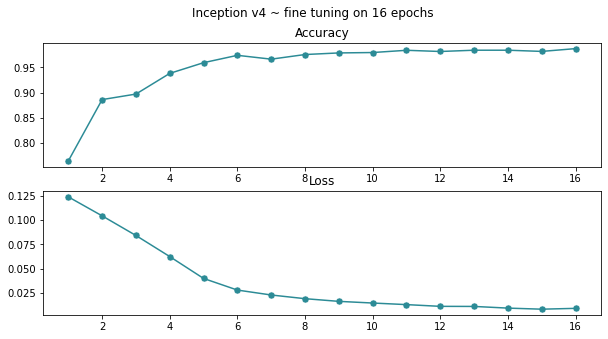

In [14]:
fig = plt.figure(figsize=(10,5))
fig.suptitle(f"Inception v4 ~ fine tuning on {num_epochs} epochs")
ax1 = plt.subplot(211)
ax2 = plt.subplot(212)
ax1.title.set_text("Accuracy")
ax2.title.set_text("Loss")

sns.scatterplot(data=accuracy_dict, ax=ax1, color="#2C8B96", s=50)
sns.lineplot(data=accuracy_dict, ax=ax1, color="#2C8B96")
sns.scatterplot(data=loss_dict, ax=ax2, color="#2C8B96", s=50)
sns.lineplot(data=loss_dict, ax=ax2, color="#2C8B96")

plt.plot()

In [15]:
accuracy_dict

{1: 0.764575411913815,
 2: 0.8862484157160964,
 3: 0.8971799746514575,
 4: 0.938212927756654,
 5: 0.9594423320659062,
 6: 0.9740177439797212,
 7: 0.9664131812420785,
 8: 0.9756020278833967,
 9: 0.9787705956907478,
 10: 0.9795627376425855,
 11: 0.9839987325728771,
 12: 0.9816223067173637,
 13: 0.9841571609632446,
 14: 0.9841571609632446,
 15: 0.9817807351077313,
 16: 0.9873257287705957}